In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Define values for years of interest, demographic groups, and disability/English variables

years = [1998, 2002, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2022]

groups = ['White', 'Black', 'Hispanic', 'Asian/Pacific Islander', 'American Indian/Alaska Native', 'Two or more races', 
          'Identified as students with disabilities', 'Not identified as students with disabilities', 'ELL', 'Not ELL']

variables = ['SDRACE', 'SDRACE', 'SDRACE', 'SDRACE', 'SDRACE', 'SDRACE', 
             'IEP', 'IEP', 'LEP', 'LEP']


In [3]:
# Function to call API for average NAEP scores in AL, reading, grade 8, with parameters for variable and year, and error handling

def get_naep_data(year, variable):
    url = "https://www.nationsreportcard.gov/Dataservice/GetAdHocData.aspx"
    params = {
        "type": "data",
        "subject": "reading",
        "grade": "8",
        "subscale": "RRPCM",
        "variable": variable,
        "jurisdiction": "AL",
        "stattype": "MN:MN",
        "year": year
    }
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        print(f"Failed to get data for year {year}, variable {variable}")
        print(f"Status code: {response.status_code}")
        print(f"Response content: {response.content}")
        return None
    
    try:
        data = response.json()
    except ValueError as e:
        print(f"Error decoding JSON for year {year}, variable {variable}")
        print(f"Response content: {response.content}")
        return None
    
    if 'result' not in data:
        print(f"'result' key not found in the response for year {year}, variable {variable}")
        print(f"Response content: {data}")
        return None
    
    return data['result']


In [4]:
# Function to call API for average NAEP scores with significance, in AL, reading, grade 8, with parameters for variable and year

def get_significance_data(year1, year2, variable):
    url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx"
    params = {
        "type": "sigacrossyear",
        "subject": "reading",
        "grade": "8",
        "subscale": "RRPCM",
        "variable": variable,
        "jurisdiction": "AL",
        "stattype": "MN:MN",
        "Year": f"{year1},{year2}"
    }
    response = requests.get(url, params=params)
    try:
        data = response.json()
        return data['result']
    except ValueError:
        print(f"Error decoding JSON for years {year1} and {year2}, variable {variable}")
        print(f"Response content: {response.content}")
        return None


In [5]:
# Establish initial data dictionary
data = {year: [] for year in years}

# Loop through group/variable/year combos to populate table
for group, variable in zip(groups, variables):
    for year in years:
        naep_data = get_naep_data(year, variable)
        score = '‡'  # Default to '‡' for when 'Reporting Standards Not Met'
        if naep_data:
            for item in naep_data:
                if item['variable'] == variable and item['varValueLabel'] == group:
                    score = item['value'] if item['value'] < 999 else '‡'  # API returns '999' for '‡', so this switches it back
                    if isinstance(score, (int, float)):
                        score = f"{score:.2f}"  # Format score to 2 decimal places
                    break
        data[year].append(score)

# Convert data to tabular pandas dataframe
df = pd.DataFrame(data, index=groups)


In [6]:
# Check significance and update table
for group, variable in zip(groups, variables):
    for year in years[:-1]:  # Skip 2022
        significance_data = get_significance_data(year, 2022, variable)
        if significance_data:
            for item in significance_data:
                if item['variable'] == variable and item['valLabel'] == group:
                    if item.get('sig', '') in ['LOWER', 'HIGHER']:  # Significant difference markers per API
                        if not df.loc[group, year].endswith('*'):  # Check if * is already appended
                            df.loc[group, year] = f"{df.loc[group, year]}*"  # Add '*' to mark significantly different score from 2022


In [7]:
# Rename index values per task specifications
df.rename(index={'Two or more races': '2 or More Races', 
                 'Identified as students with disabilities': 'SD', 
                 'Not identified as students with disabilities': 'Not SD'}, inplace=True)

In [8]:
display(df)

,1998,2002,2003,2005,2007,2009,2011,2013,2015,2017,2019,2022
White,264.61,263.94,262.42,263.48,261.48,264.41,267.73*,266.46,266.87*,268.11*,261.09,261.82
Black,236.71,233.73,236.90,234.70,235.90,237.79,242.83*,241.35*,243.24*,241.16*,239.32,234.35
Hispanic,‡,‡,‡,‡,249.97,245.06,246.46,248.88,252.48,243.22,246.20,244.79
Asian/Pacific Islander,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡
American Indian/Alaska Native,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡
2 or More Races,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡
SD,‡,211.07,205.67,207.44,202.56*,207.62,216.83,209.99,212.82,215.81,209.17,212.06
Not SD,257.66,258.16,258.77,257.48,257.18,259.46,262.44*,261.99*,263.49*,262.28*,258.80,256.70
ELL,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,‡,212.60
Not ELL,255.05,252.61,253.47,252.22,252.20,255.47,258.97*,257.98*,259.21*,258.67*,254.00,252.60


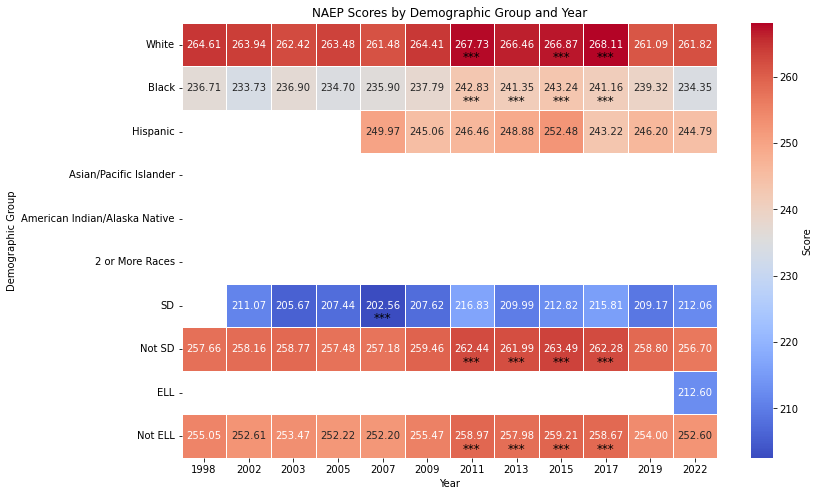

In [9]:
# Visualize data with a heatmap and significance marker '***'

# Replace '‡' with NaN
df_clean = df.replace('‡', np.nan)

# Extract numeric part and convert to float
df_numeric = df_clean.replace({r'\*': ''}, regex=True).astype(float)

# Create a mask for significant scores
sig_mask = df_clean.applymap(lambda x: isinstance(x, str) and '*' in x)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'Score'})

# Overlay the significant markers
for y in range(df.shape[0]):
    for x in range(df.shape[1]):
        if sig_mask.iat[y, x]:
            plt.text(x + 0.5, y + 0.8, '***', color='black', fontsize=12, ha='center', va='center')

# Set the title and labels
plt.title('NAEP Scores by Demographic Group and Year')
plt.xlabel('Year')
plt.ylabel('Demographic Group')

plt.show()


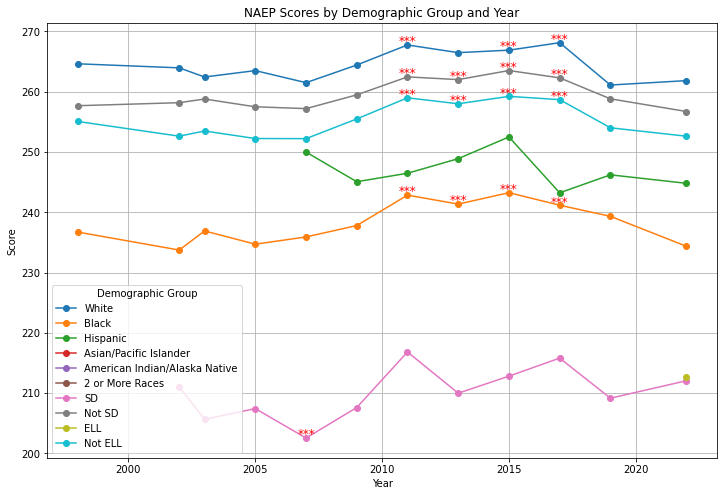

In [10]:
# Visualize data with a line-graph and significance marker '***'

plt.figure(figsize=(12, 8))

# Loop through each group and plot its scores over time
for group in df.index:
    plt.plot(df.columns, df_numeric.loc[group], marker='o', label=group)

# Highlight significant scores
for y in range(df.shape[0]):
    for x in range(df.shape[1]):
        if sig_mask.iat[y, x]:
            plt.text(df.columns[x], df_numeric.iat[y, x], '***', color='red', fontsize=12, ha='center')

# Set the title and labels
plt.title('NAEP Scores by Demographic Group and Year')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend(title='Demographic Group')
plt.grid(True)

plt.show()


In [11]:
# Ensure the 'Group' column is added correctly
df_clean['Group'] = df_clean.index

# Convert to long format
df_long = df_clean.reset_index(drop=True).melt(id_vars='Group', var_name='Year', value_name='Score')

# Handle '‡' values and significant markers
df_long['Numeric_Score'] = df_long['Score'].replace({'‡': np.nan, r'\*': ''}, regex=True).astype(float)
df_long['Significant'] = df_long['Score'].apply(lambda x: '*' in str(x) if isinstance(x, str) else False)

# Ensure 'Year' is a string value
df_long['Year'] = df_long['Year'].astype(str)


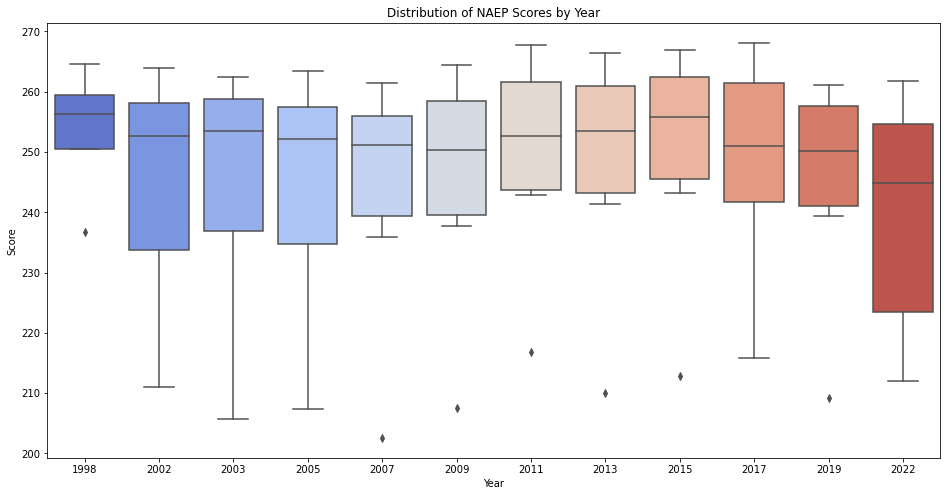

In [14]:
# Adjust figure size for the box plot
plt.figure(figsize=(16, 8))

# Plot the box plot
sns.boxplot(x='Year', y='Numeric_Score', data=df_long, palette="coolwarm")

# Set the title and labels
plt.title('Distribution of NAEP Scores by Year')
plt.xlabel('Year')
plt.ylabel('Score')

plt.show()

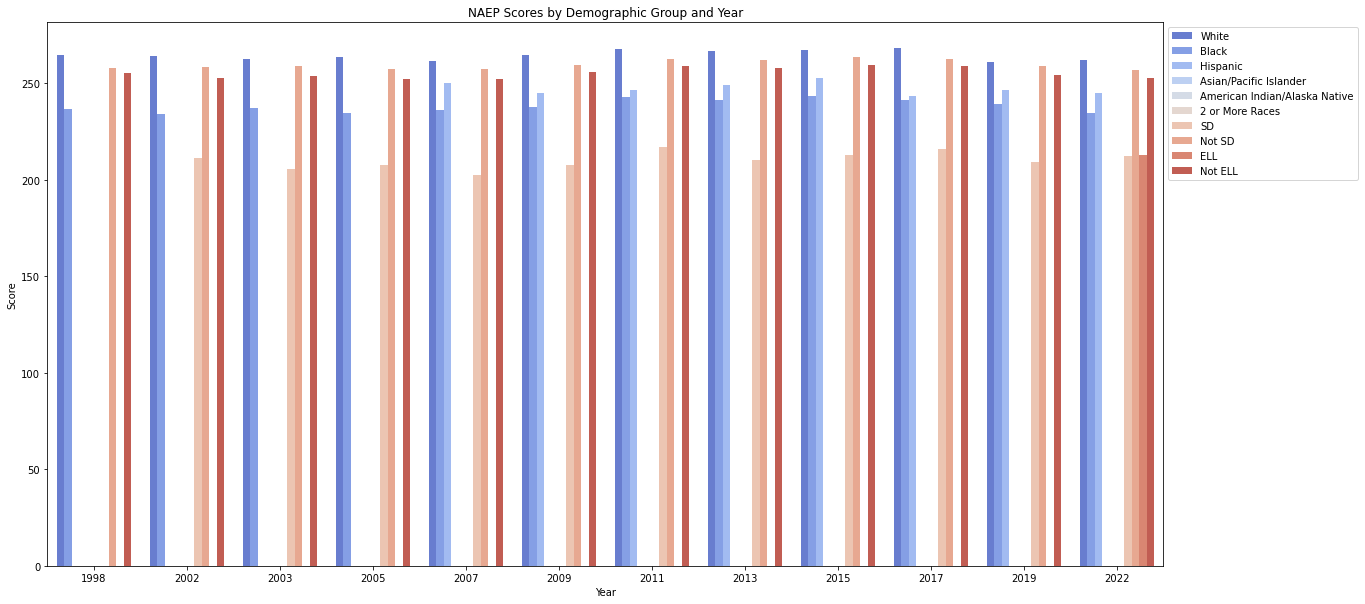

In [17]:
# Ensure Year is a string
df_long['Year'] = df_long['Year'].astype(str)

# Adjust figure size for the clustered bar chart
plt.figure(figsize=(20, 10))  # Adjust size as needed

# Plot the clustered bar chart
sns.barplot(x='Year', y='Numeric_Score', hue='Group', data=df_long, palette="coolwarm")

# Set the title and labels
plt.title('NAEP Scores by Demographic Group and Year')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend(title='Demographic Group')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()

In [18]:
# Import widgets for interactive graph with dropdown
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Replace '‡' with NaN and ensure numeric conversion
df_clean = df.replace('‡', np.nan)
df_numeric = df_clean.replace({r'\*': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

# Create a mask for significant scores
sig_mask = df_clean.applymap(lambda x: isinstance(x, str) and '*' in x)

# Dropdown widget
year_dropdown = widgets.Dropdown(
    options=[year for year in df_numeric.columns],
    value=df_numeric.columns[0],  # Default to the first year
    description='Year:',
)

# Function to update the bar chart based on selected year
def update_bar_chart(year):
    # Ensure the year exists in the DataFrame
    if year not in df_numeric.columns:
        print(f"Year {year} is not in the data.")
        return
    
    # Create the bar chart
    fig = go.Figure()
    
    # Plotting the data
    fig.add_trace(go.Bar(
        x=df_numeric.index,
        y=df_numeric[year],
        marker_color='royalblue',
        name='Scores'
    ))
    
    # Add significant markers
    for i, is_significant in enumerate(sig_mask[year]):
        if is_significant:
            fig.add_annotation(
                x=df_numeric.index[i],
                y=df_numeric[year][i],
                text='***',
                showarrow=True,
                arrowhead=2,
                ax=0,
                ay=-40
            )
    
    # Update layout
    fig.update_layout(
        title=f'NAEP Scores by Demographic Group in {year}',
        xaxis_title='Demographic Group',
        yaxis_title='Score',
        xaxis_tickangle=-45,
        template='plotly_white'
    )
    
    # Show the plot
    fig.show()

# Set up the interactive widget
interactive_plot = widgets.interactive(update_bar_chart, year=year_dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='Year:', options=(1998, 2002, 2003, 2005, 2007, 2009, 2011, 2013, 2…